# Mathematical Underpinnings - Lab 6

In [71]:
from sklearn.metrics import mutual_info_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


## Useful functions

In [72]:
def discetize_2bins(X):
    X_discrete = 1*(X >= 0)
    return X_discrete

In [73]:
def conditional_permutation(X, Z):

    z_values = np.unique(Z)
    n_z_values = len(z_values)
    n = len(Z)

    X_b = np.zeros(n)

    for i in range(n_z_values):

        z_value_tmp = z_values[i]

        X_b[Z == z_value_tmp] = np.random.permutation(X[Z == z_value_tmp])

    return X_b

In [74]:
def conditional_mutual_information(X, Y, Z):

    z_values = np.unique(Z)
    n_z_values = len(z_values)
    n = len(Z)

    cmi = 0

    for i in range(n_z_values):

        z_value_tmp = z_values[i]
        z_condition = (Z == z_value_tmp)

        X_z = X[z_condition]
        Y_z = Y[z_condition]

        mi_XY_z = mutual_info_score(X_z, Y_z)
        p_z = np.sum(z_condition)/n

        cmi += p_z*mi_XY_z

    return cmi

In [75]:
# II(X;Y;Z)
def interaction_information(X, Y, Z):
    return conditional_mutual_information(X, Y, Z) - mutual_info_score(X, Y)

In [76]:
# II(X;Y;Z1;Z2)
def interaction_information2(X, Y, Z1, Z2):
    Z_1_and_2 = 2*Z2 + Z1
    return interaction_information(X, Y, Z_1_and_2) - interaction_information(X, Y, Z1) - interaction_information(X, Y, Z2)

## Task 1

In [77]:
def secmi2(X, Y, Z):
    
    ii = 0
    for iter in range(len(np.unique(Z))):
        ii += interaction_information(X, Y, Z[:, iter])

    return mutual_info_score(X, Y) + ii

def secmi3(X, Y, Z):

    ii = 0
    ii2 = 0
    for iter in range(len(np.unique(Z))):
        ii += interaction_information(X, Y, Z[:, iter])
        for iter2 in range(iter+1, len(np.unique(Z))):
            ii2 += interaction_information2(X, Y, Z[:, iter], Z[:, iter2])

    return mutual_info_score(X, Y) + ii + ii2


### a)

In [78]:
def cond_indep_test_permutation(X, Y, Z, B, stat):

    n_col_Z = Z.shape[1]
    Z_1dim = np.dot(Z, 2**np.linspace(0, n_col_Z-1, n_col_Z))

    if stat == "cmi":
        stat_value = conditional_mutual_information(X, Y, Z_1dim)
    if stat == "secmi2":
        stat_value = secmi2(X, Y, Z)
    if stat == "secmi3":
        stat_value = secmi3(X, Y, Z)

    condition_p_value = 0
    for b in range(B):
        X_b = conditional_permutation(X, Z_1dim)

        if stat == "cmi":
            stat_value_b = conditional_mutual_information(X_b, Y, Z_1dim)
        if stat == "secmi2":
            stat_value_b = secmi2(X_b, Y, Z)
        if stat == "secmi3":
            stat_value_b = secmi3(X_b, Y, Z)

        if stat_value <= stat_value_b:
            condition_p_value += 1

    p_value = (1 + condition_p_value)/(1 + B)

    return 2*len(X)*stat_value, p_value

### b)

In [81]:
def sample_data(n, seed = 42):
    np.random.seed(seed)
    Y = np.where(np.random.normal(0, 1, n)>=0, 1, -1)
    Z = np.where(np.random.normal(0, 1, 3*n) + Y.repeat(3)>=0, 1, -1).reshape(n, 3)
    X = np.where(np.random.normal(0, 1, n) + Z[:, 0]>=0, 1, -1)

    return X, Y, Z 

In [84]:
X, Y, Z = sample_data(1000)

# conditional independence tests

B = 100

stat = "cmi"
stat_value, p_value = cond_indep_test_permutation(X, Y, Z[:, 0:2], B, stat)
print("p-value for the conditional independence test with the CMI(X, Y | (Z1, Z2)): ", p_value)
stat_value, p_value = cond_indep_test_permutation(X, Y, Z[:, 1:3], B, stat)
print("p-value for the conditional independence test with the CMI(X, Y | (Z2, Z3)): ", p_value)

stat = "secmi2"

stat_value, p_value = cond_indep_test_permutation(X, Y, Z[:, 0:2], B, stat)
print("p-value for the conditional independence test with the seCMI2(X, Y | (Z1, Z2)): ", p_value)
stat_value, p_value = cond_indep_test_permutation(X, Y, Z[:, 1:3], B, stat)
print("p-value for the conditional independence test with the seCMI2(X, Y | (Z2, Z3)): ", p_value)

stat = "secmi3"
stat_value, p_value = cond_indep_test_permutation(X, Y, Z[:, 0:2], B, stat)
print("p-value for the conditional independence test with the seCMI3(X, Y | (Z1, Z2)): ", p_value)
stat_value, p_value = cond_indep_test_permutation(X, Y, Z[:, 1:3], B, stat)
print("p-value for the conditional independence test with the seCMI3(X, Y | (Z2, Z3)): ", p_value)



p-value for the conditional independence test with the CMI(X, Y | (Z1, Z2)):  0.3465346534653465
p-value for the conditional independence test with the CMI(X, Y | (Z2, Z3)):  0.009900990099009901
p-value for the conditional independence test with the seCMI2(X, Y | (Z1, Z2)):  0.9504950495049505
p-value for the conditional independence test with the seCMI2(X, Y | (Z2, Z3)):  0.009900990099009901
p-value for the conditional independence test with the seCMI3(X, Y | (Z1, Z2)):  0.31683168316831684
p-value for the conditional independence test with the seCMI3(X, Y | (Z2, Z3)):  0.009900990099009901


In [87]:
from tqdm import tqdm
N = 100
B = 50
scenarios = ["sc1", "sc2"]
stats = ["cmi", "secmi2", "secmi3"]

p_values = np.zeros((N, len(scenarios), len(stats)))

for i in tqdm(range(N)):
    for stat in stats:
        for j, scenario in enumerate(scenarios):
            X, Y, Z = sample_data(1000, seed = i)
            if scenario == "sc1":
                st = 0
                en = 2
            if scenario == "sc2":
                st = 1
                en = 3
            stat_value, p_value = cond_indep_test_permutation(X, Y, Z[:, st:en], B, stat)
            p_values[i, j, stats.index(stat)] = p_value

p_values_df = pd.DataFrame(p_values.reshape(N, -1), columns = [f"{scenario}_{stat}" for scenario in scenarios for stat in stats])



100%|██████████| 100/100 [07:27<00:00,  4.47s/it]


In [88]:
p_values_df.head()

,sc1_cmi,sc1_secmi2,sc1_secmi3,sc2_cmi,sc2_secmi2,sc2_secmi3
0,0.509804,0.313725,0.509804,0.019608,0.019608,0.019608
1,0.294118,0.431373,0.294118,0.019608,0.019608,0.019608
2,0.313725,0.215686,0.313725,0.019608,0.019608,0.019608
3,1.000000,0.764706,1.000000,0.019608,0.019608,0.019608
4,0.607843,1.000000,0.607843,0.019608,0.019608,0.019608


In [89]:
alpha = 0.05
rejections = np.sum(p_values < alpha, axis = 0)
rejections_df = pd.DataFrame(rejections.reshape(1, -1), columns = [f"{scenario}_{stat}" for scenario in scenarios for stat in stats])
rejections_df = rejections_df.T
rejections_df.columns = ["number of rejections"]
rejections_df = rejections_df.reset_index()
rejections_df["scenario"] = rejections_df["index"].apply(lambda x: x.split("_")[0])
rejections_df["statistic"] = rejections_df["index"].apply(lambda x: x.split("_")[1])
rejections_df = rejections_df.drop("index", axis = 1)
rejections_df.set_index(["scenario", "statistic"], inplace = True)
rejections_df


number of rejections
scenario statistic                      
sc1      cmi                           4
         secmi2                        4
         secmi3                        4
sc2      cmi                         100
         secmi2                      100
         secmi3                      100

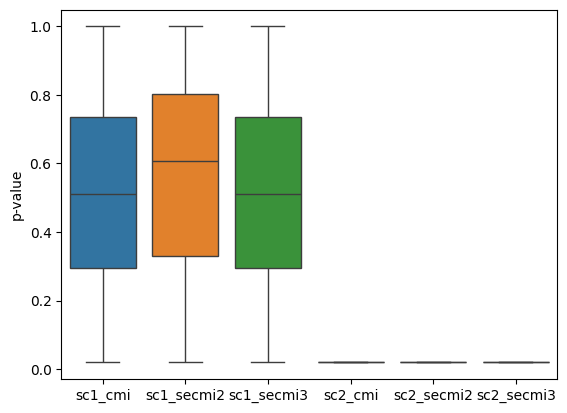

In [90]:
sns.boxplot(data = p_values_df)
plt.ylabel("p-value")
plt.show()


### c)

In [96]:
def sample_data2(n, seed = 42):
    np.random.seed(seed)

    X = np.random.binomial(1, 0.5, n)
    Z1 = np.random.binomial(1, 0.5, n)
    Z2 = np.random.binomial(1, 0.5, n)
    Z3 = np.random.binomial(1, 0.5, n)

    Y = np.zeros(n)
    size1 = np.sum((X+Z1+Z2)% 2 == 1)
    Y[(X+Z1+Z2)% 2 == 1] = np.random.choice([0, 1], size = (size1,), p = [0.2, 0.8])
    Y[(X+Z1+Z2)% 2 == 0] = np.random.choice([0, 1], size = (n - size1, ), p = [0.8, 0.2])

    return X, Y, Z1, Z2, Z3

In [97]:
N = 100
scenarios = ["sc1", "sc2"]
stats = ["cmi", "secmi2", "secmi3"]
B = 50

p_values = np.zeros((N, len(scenarios), len(stats)))

for i in tqdm(range(N)):
    for stat in stats:
        for j, scenario in enumerate(scenarios):
            X, Y, Z1, Z2, Z3 = sample_data2(1000, seed = i)
            if scenario == "sc1":
                Z = np.array([Z1, Z2]).T
            if scenario == "sc2":
                Z = np.array([Z2, Z3]).T
            stat_value, p_value = cond_indep_test_permutation(X, Y, Z, B, stat)
            p_values[i, j, stats.index(stat)] = p_value

p_values_df = pd.DataFrame(p_values.reshape(N, -1), columns = [f"{scenario}_{stat}" for scenario in scenarios for stat in stats])

100%|██████████| 100/100 [07:25<00:00,  4.45s/it]


In [100]:
alpha = 0.05
rejections = np.sum(p_values < alpha, axis = 0)
rejections_df = pd.DataFrame(rejections.reshape(1, -1), columns = [f"{scenario}_{stat}" for scenario in scenarios for stat in stats])
rejections_df = rejections_df.T
rejections_df.columns = ["number of rejections"]
rejections_df = rejections_df.reset_index()
rejections_df["scenario"] = rejections_df["index"].apply(lambda x: x.split("_")[0])
rejections_df["statistic"] = rejections_df["index"].apply(lambda x: x.split("_")[1])
rejections_df = rejections_df.drop("index", axis = 1)
rejections_df.set_index(["scenario", "statistic"], inplace = True)
rejections_df


number of rejections
scenario statistic                      
sc1      cmi                         100
         secmi2                        3
         secmi3                      100
sc2      cmi                           8
         secmi2                        3
         secmi3                        8

In [101]:
p_values_df.head()

,sc1_cmi,sc1_secmi2,sc1_secmi3,sc2_cmi,sc2_secmi2,sc2_secmi3
0,0.019608,0.882353,0.019608,0.588235,0.470588,0.588235
1,0.019608,0.254902,0.019608,0.196078,0.098039,0.196078
2,0.019608,0.137255,0.019608,0.686275,0.490196,0.686275
3,0.019608,0.470588,0.019608,0.470588,0.509804,0.470588
4,0.019608,0.941176,0.019608,0.039216,0.431373,0.039216


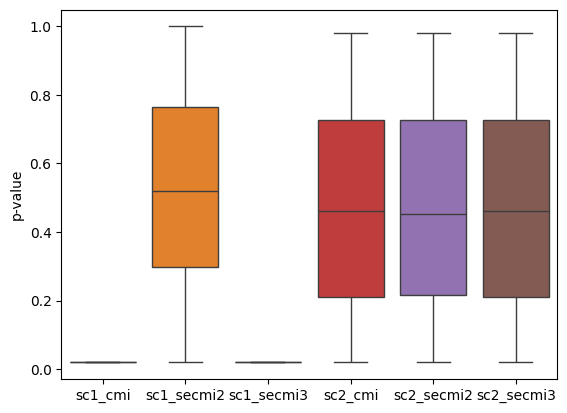

In [102]:
sns.boxplot(data = p_values_df)
plt.ylabel("p-value")
plt.show()

## Task 2
 
in R